1. Хочу посмотреть, какие признаки вообще есть

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train.csv')

from tabulate import tabulate
print(tabulate([(col, dtype) for col, dtype in zip(df.columns, df.dtypes)],
               headers=['Признак', 'Тип данных'], tablefmt='grid'))

+----------------------------+--------------+
| Признак                    | Тип данных   |
+============================+==============+
| ApplicationDate            | object       |
+----------------------------+--------------+
| Age                        | float64      |
+----------------------------+--------------+
| AnnualIncome               | float64      |
+----------------------------+--------------+
| CreditScore                | float64      |
+----------------------------+--------------+
| LoanAmount                 | float64      |
+----------------------------+--------------+
| LoanDuration               | float64      |
+----------------------------+--------------+
| MaritalStatus              | object       |
+----------------------------+--------------+
| NumberOfDependents         | float64      |
+----------------------------+--------------+
| HomeOwnershipStatus        | object       |
+----------------------------+--------------+
| MonthlyDebtPayments        | flo

2. Удалю все строки где есть NULL-value и проведу анализ выбросов целевой переменной

(11017, 36)
В данных больше нет null значений
(9986, 36)
RiskScore
-9.999999e+06    115
 1.000000e+07     84
 3.704447e+01      3
 5.967628e+01      3
 6.785041e+01      3
                ... 
 4.093270e+01      1
 3.174699e+01      1
 7.617149e+01      1
 4.058056e+01      1
 5.137230e+01      1
Name: count, Length: 9334, dtype: int64


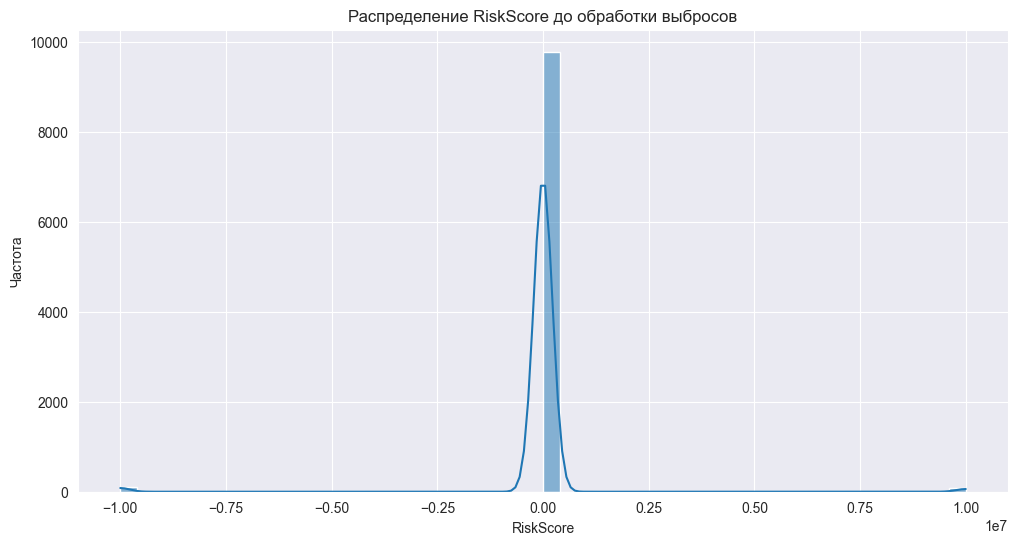

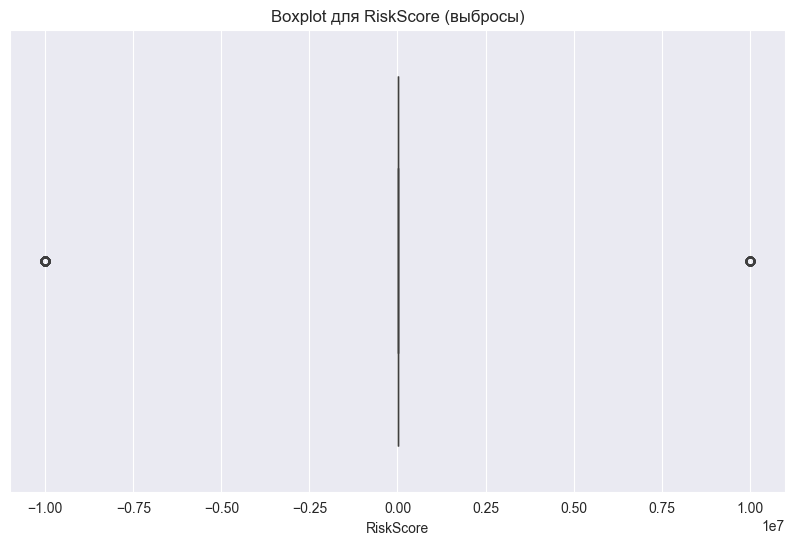


Границы выбросов:
Нижняя граница: -16.71
Верхняя граница: 114.55

Количество выбросов: 199 (1.99%)


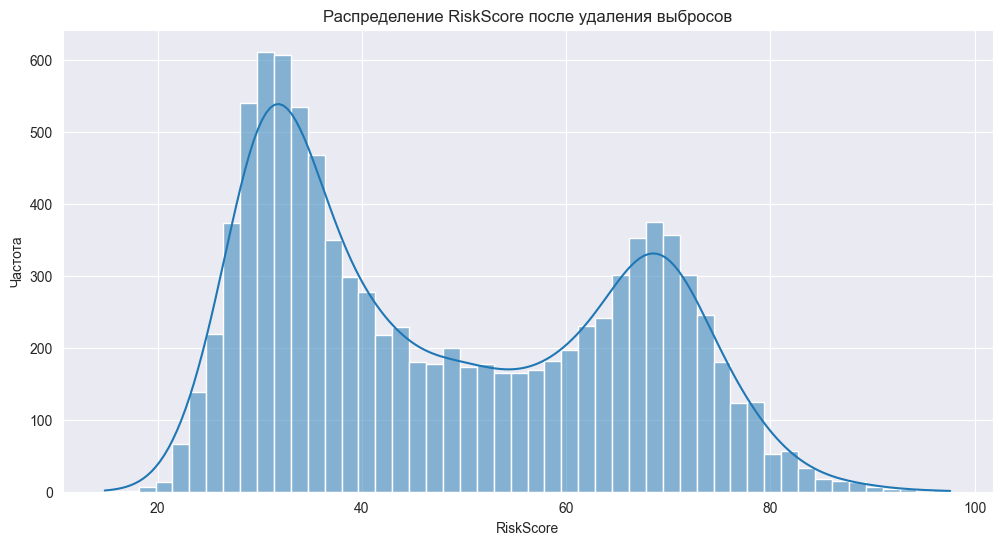

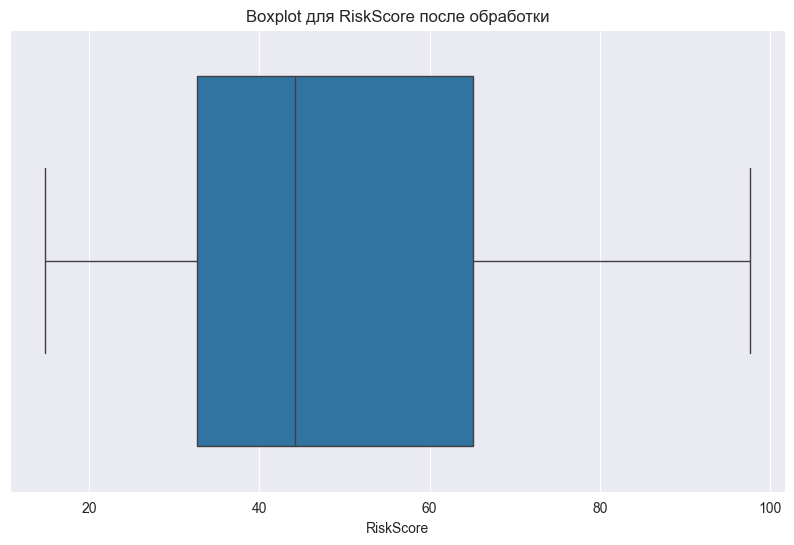


Сравнение статистик до и после:
До обработки:
count    9.986000e+03
mean    -3.099606e+04
std      1.411392e+06
min     -9.999999e+06
25%      3.251016e+01
50%      4.406128e+01
75%      6.532677e+01
max      1.000000e+07
Name: RiskScore, dtype: float64

После обработки:
count    9787.000000
mean       48.349800
std        17.255990
min        14.841417
25%        32.699940
50%        44.151002
75%        65.122034
max        97.597249
Name: RiskScore, dtype: float64


In [94]:
print(df.shape)

df_cleaned = df.dropna()
if df_cleaned.isnull().sum().sum() == 0:
    print("В данных больше нет null значений")
else:
    print("Обнаружены null значения")

print(df_cleaned.shape)

target_col = "RiskScore"
print(df_cleaned[target_col].value_counts())

plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned[target_col], bins=50, kde=True)
plt.title('Распределение RiskScore до обработки выбросов')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned[target_col])
plt.title('Boxplot для RiskScore (выбросы)')
plt.show()

Q1 = df_cleaned[target_col].quantile(0.25)
Q3 = df_cleaned[target_col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\nГраницы выбросов:")
print(f"Нижняя граница: {lower_bound:.2f}")
print(f"Верхняя граница: {upper_bound:.2f}")


outliers = df_cleaned[(df_cleaned[target_col] < lower_bound) | (df_cleaned[target_col] > upper_bound)]
print(f"\nКоличество выбросов: {len(outliers)} ({len(outliers)/len(df_cleaned)*100:.2f}%)")

df_ = df_cleaned[(df_cleaned[target_col] >= lower_bound) &
                           (df_cleaned[target_col] <= upper_bound)].copy()


plt.figure(figsize=(12, 6))
sns.histplot(df_[target_col], bins=50, kde=True)
plt.title('Распределение RiskScore после удаления выбросов')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x=df_[target_col])
plt.title('Boxplot для RiskScore после обработки')
plt.show()

print("\nСравнение статистик до и после:")
print("До обработки:")
print(df_cleaned[target_col].describe())
print("\nПосле обработки:")
print(df_[target_col].describe())

3. Посмотрим на типы признаков (их примерный состав)


In [95]:

numeric_cols = df_.select_dtypes(include=['float64']).columns.tolist()
print("\nЧисловые признаки (%d):" % len(numeric_cols))
print(numeric_cols)

categorical_cols = df_.select_dtypes(include=['object']).columns.tolist()
print("\nКатегориальные признаки (%d):" % len(categorical_cols))
print(categorical_cols)


Числовые признаки (30):
['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']

Категориальные признаки (6):
['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


4. Посмотрим на псевдо-числовые признаки

In [96]:
pseudo_numeric = []
for col in numeric_cols:
    if df_[col].nunique() < 3:
        pseudo_numeric.append(col)

if pseudo_numeric:
    print("\nВозможные псевдо-числовые признаки (мало уникальных значений):")
    print(pseudo_numeric)

    for col in pseudo_numeric:
        print(f"\nРаспределение для {col}:")
        print(df_[col].value_counts().sort_index())


Возможные псевдо-числовые признаки (мало уникальных значений):
['BankruptcyHistory', 'PreviousLoanDefaults', 'LoanApproved']

Распределение для BankruptcyHistory:
BankruptcyHistory
0.0    9272
1.0     515
Name: count, dtype: int64

Распределение для PreviousLoanDefaults:
PreviousLoanDefaults
0.0    8845
1.0     942
Name: count, dtype: int64

Распределение для LoanApproved:
LoanApproved
0.0    4775
1.0    5012
Name: count, dtype: int64


5. Значит в первую очередь будем обрабатывать (пытаться перевести в ноормальные числовые признаки) категориальные признаки: ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel'] и псевдо-числовые признаки: ['LoanDuration', 'NumberOfDependents', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'BankruptcyHistory', 'PreviousLoanDefaults', 'LoanApproved']

6. Попробуем визуализировать корреляцию чисто числовых признаков и целевой переменной

7. Выведем парные зависимости для первых 5 числовых признаков

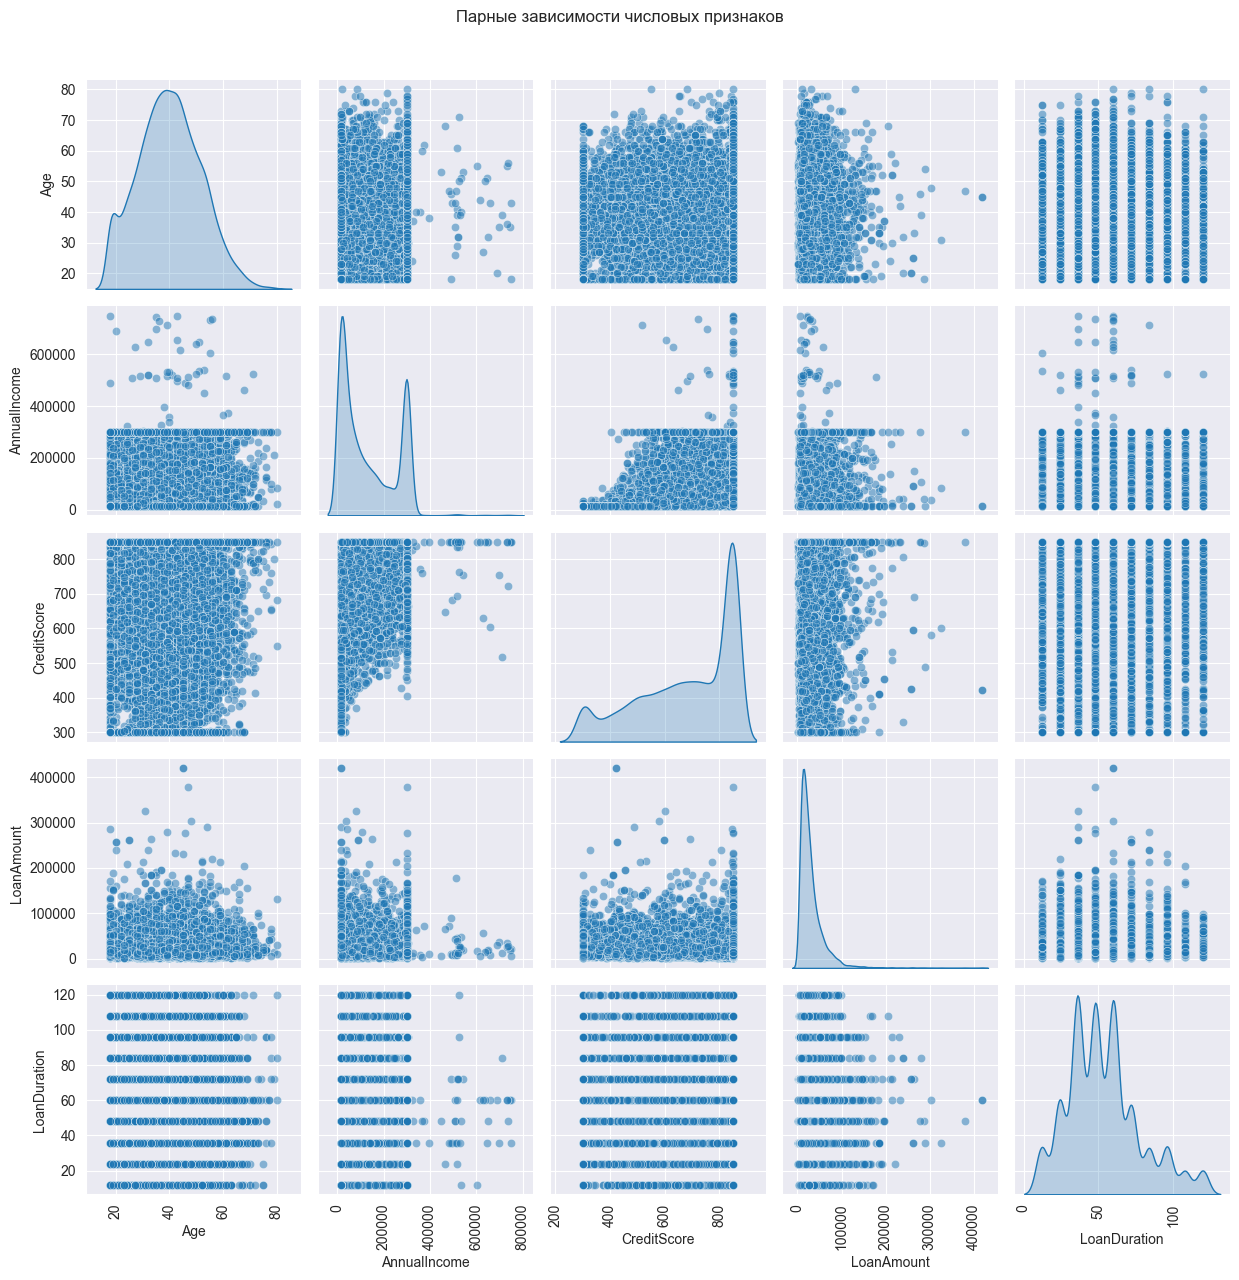

In [98]:
num_cols = df_.select_dtypes(include=['float64']).columns[:5]

g = sns.pairplot(df_[num_cols], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Парные зависимости числовых признаков', y=1.02)

for ax in g.axes.flat:
    if ax.get_xlabel():
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

9. Посмотрим на числовые признаки подробнее

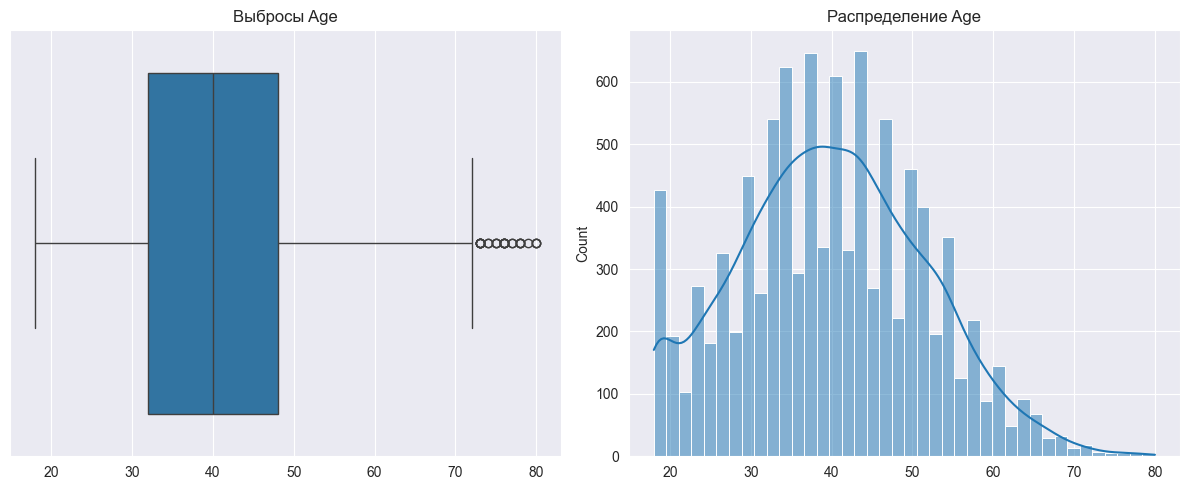

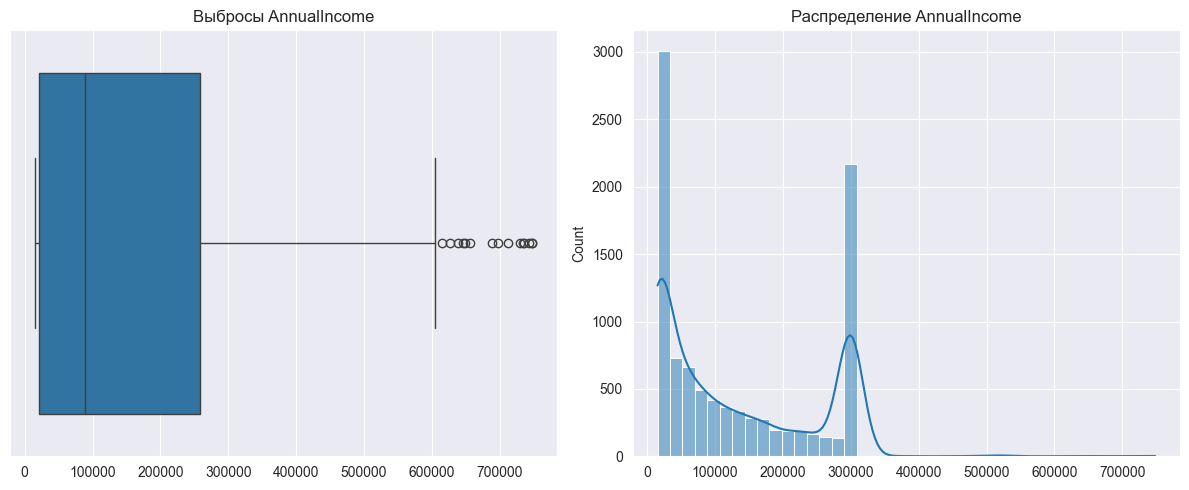

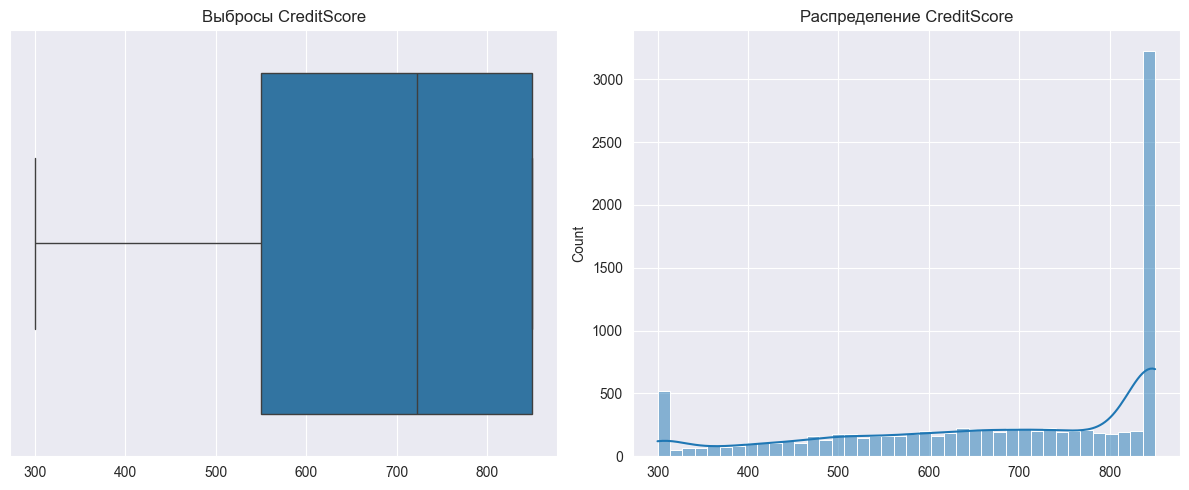

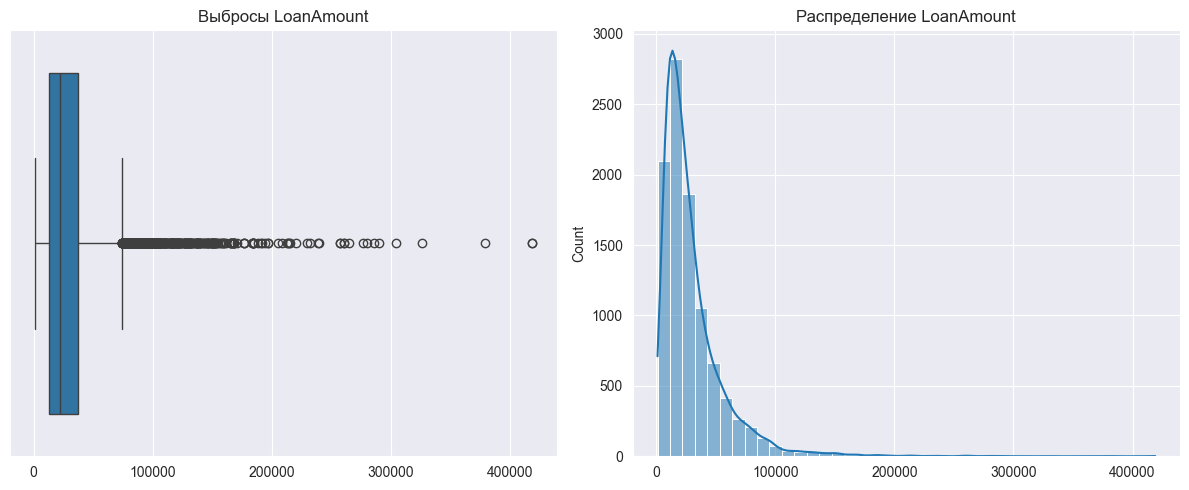

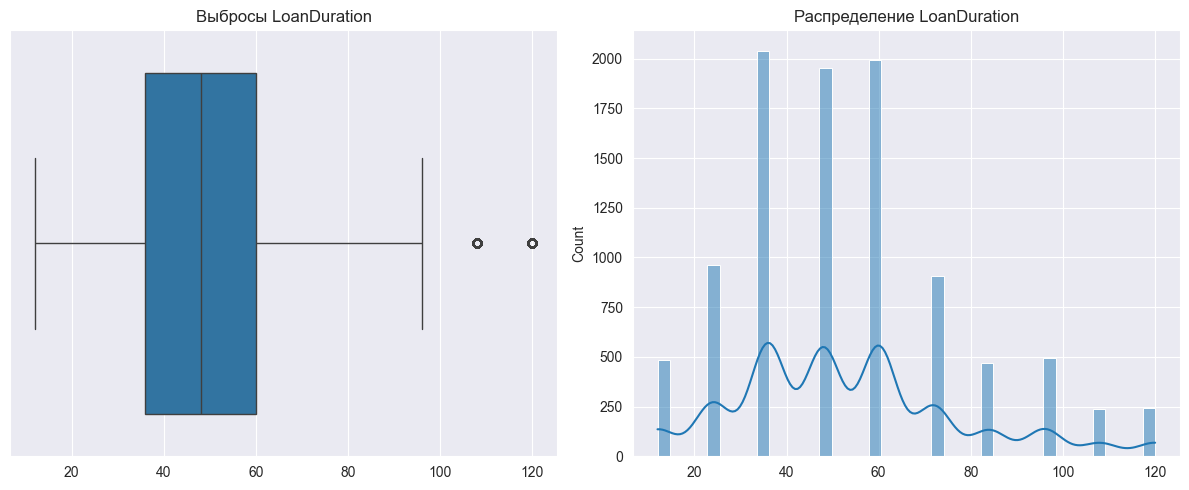

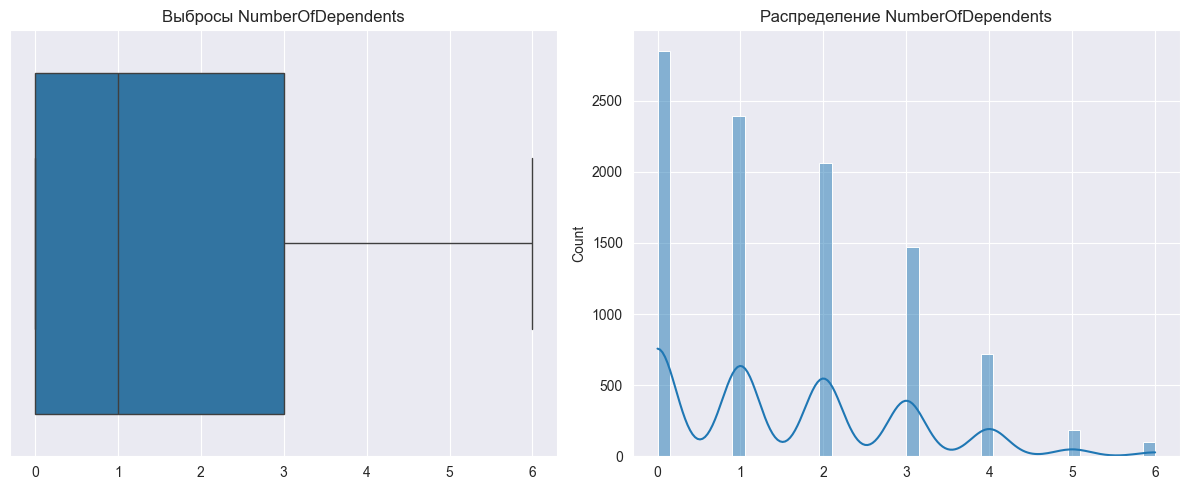

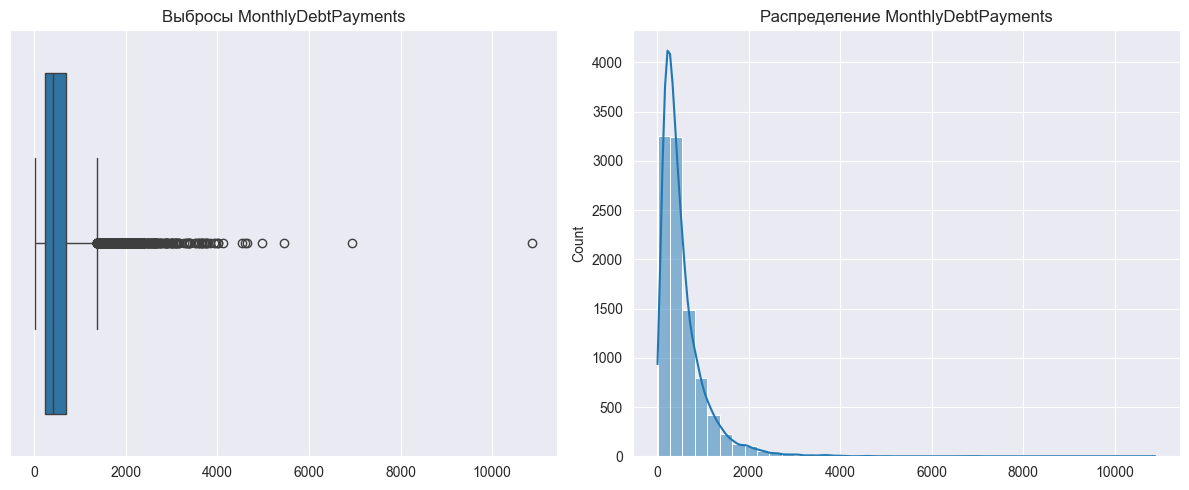

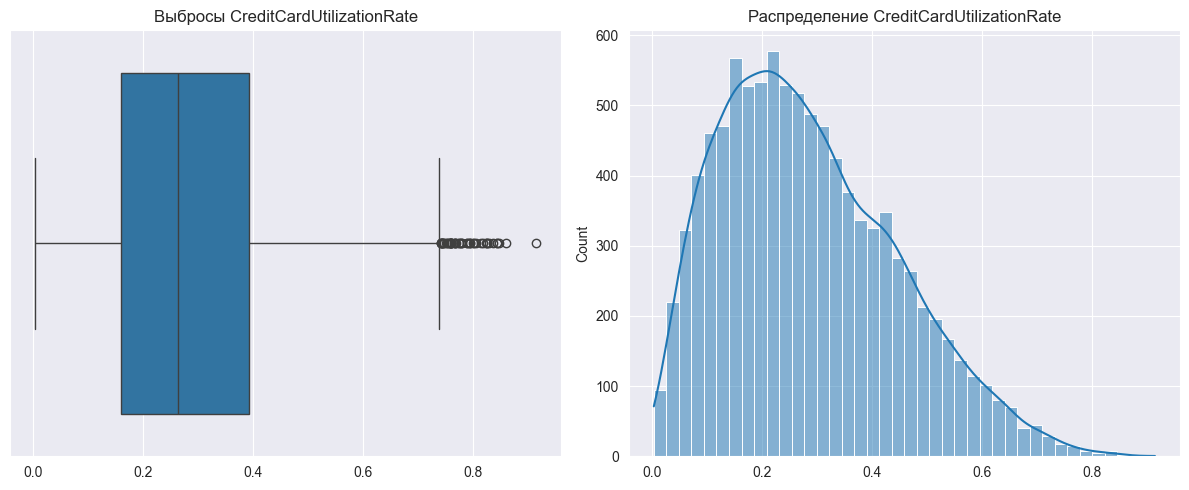

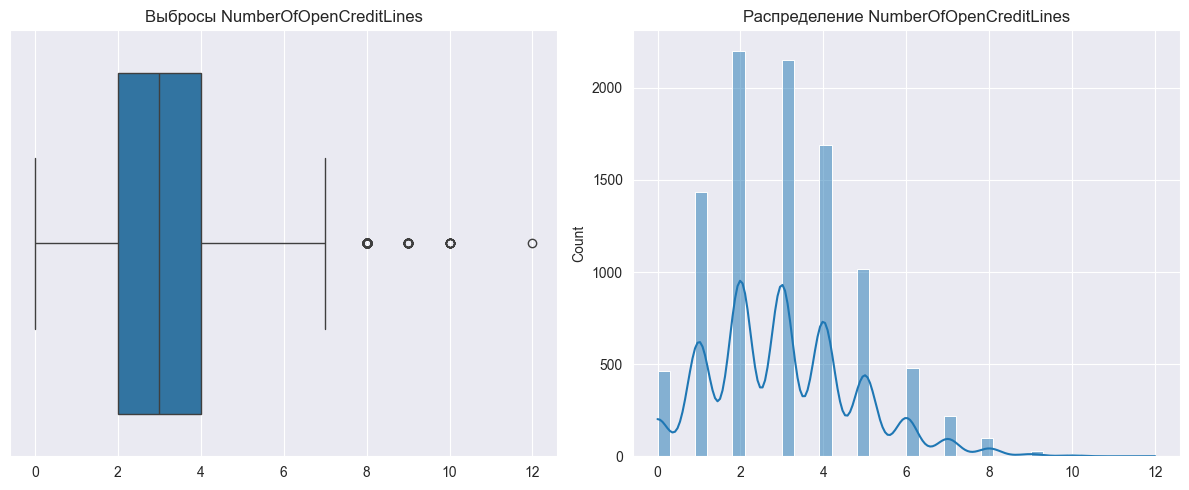

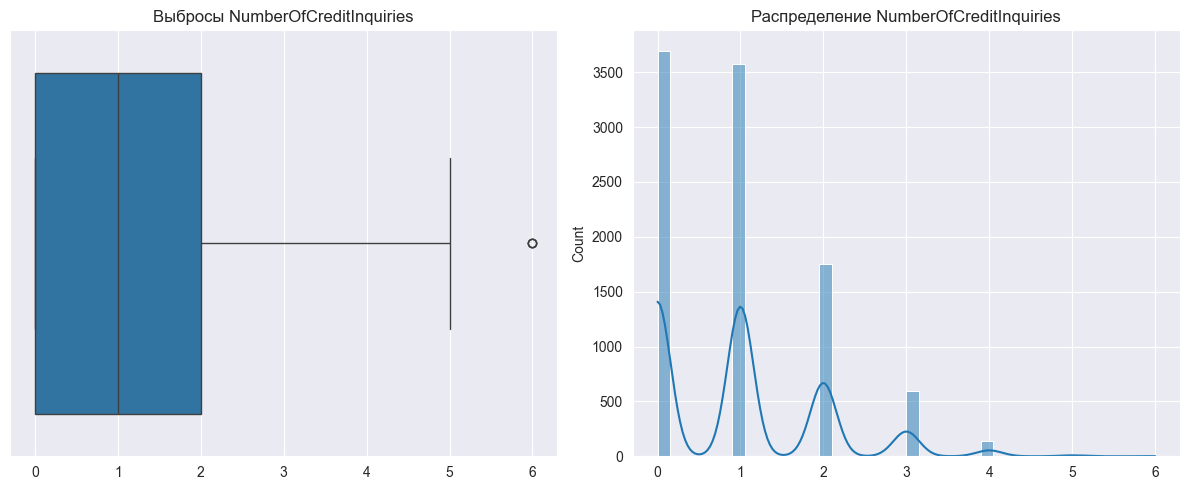

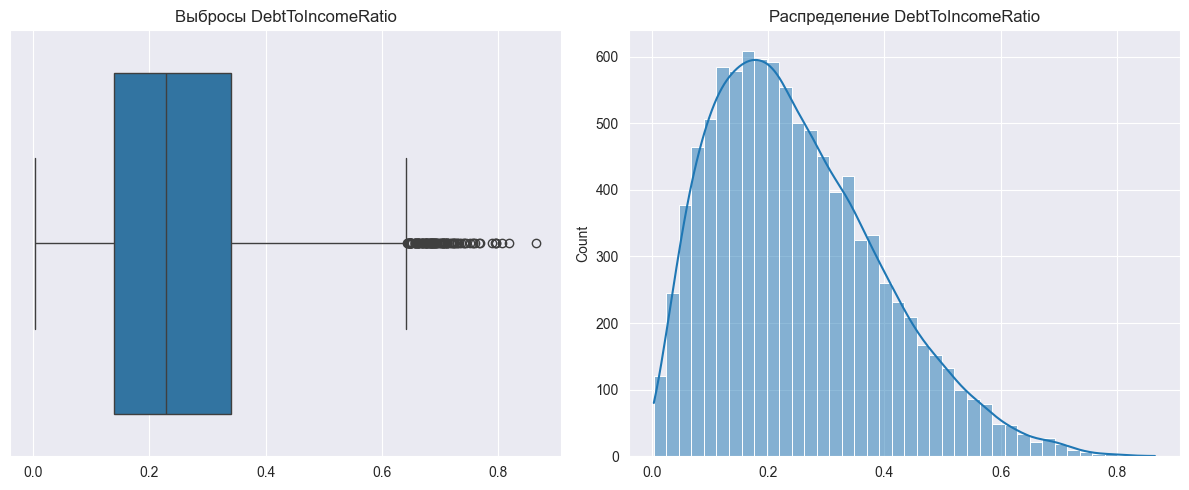

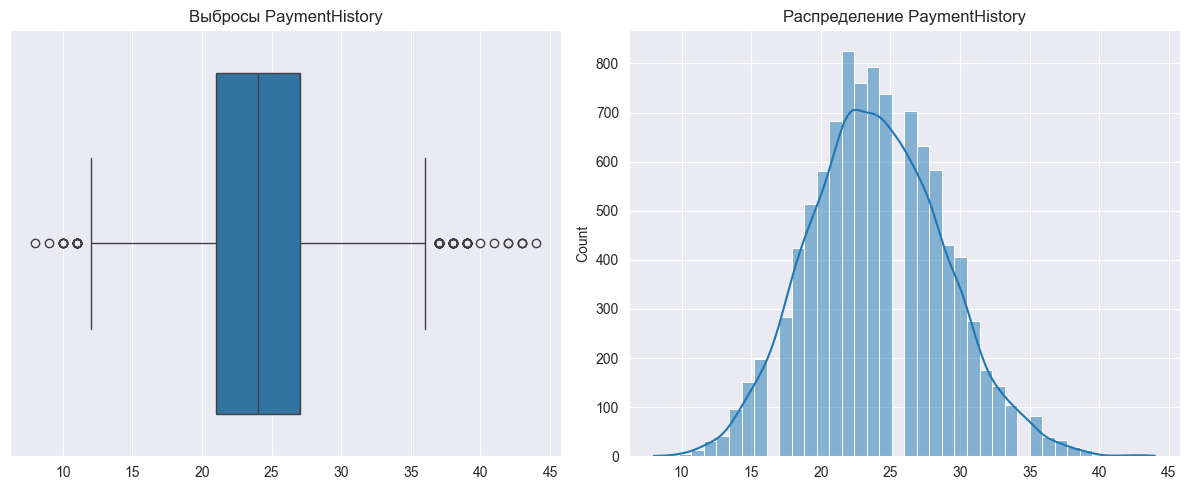

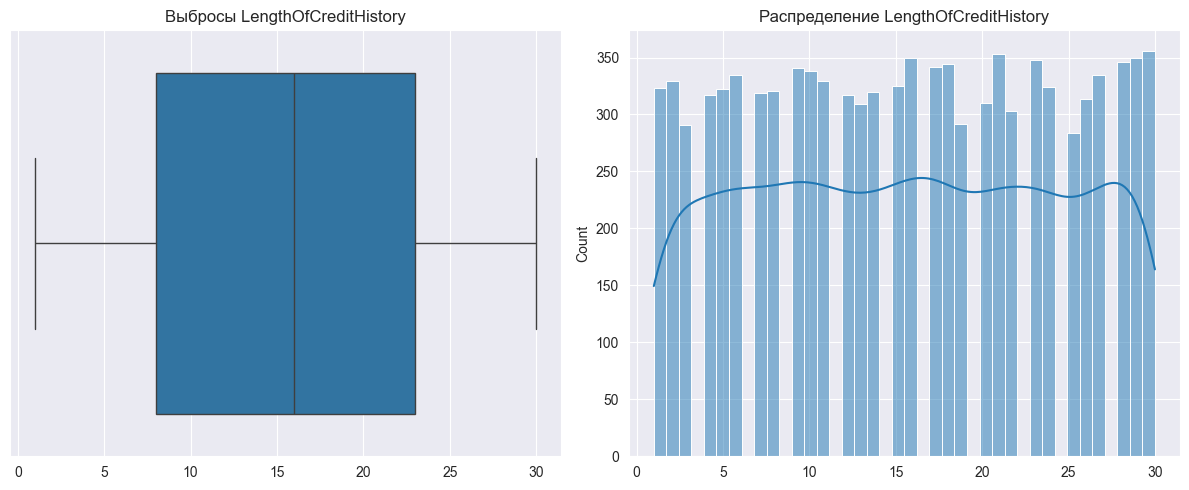

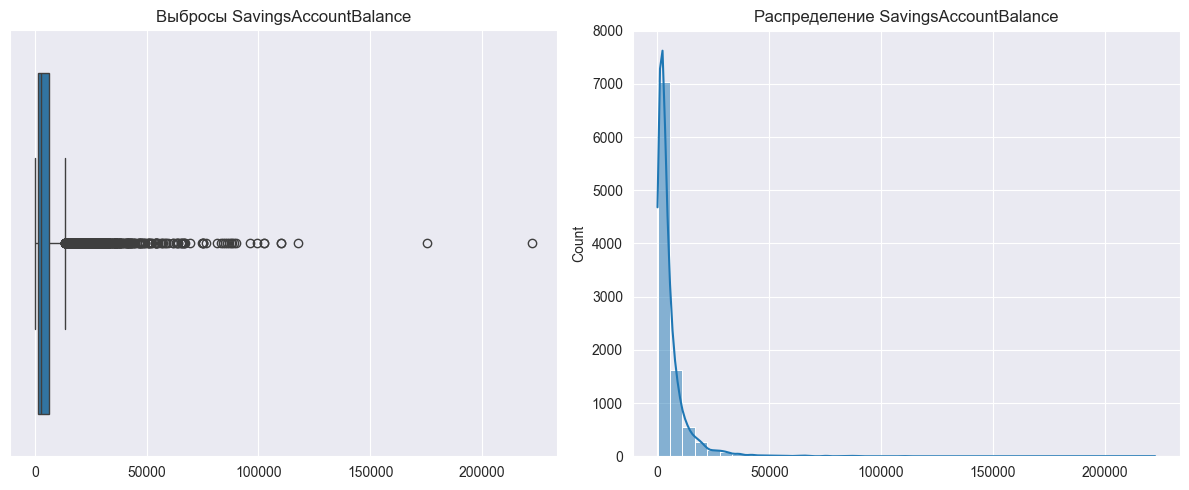

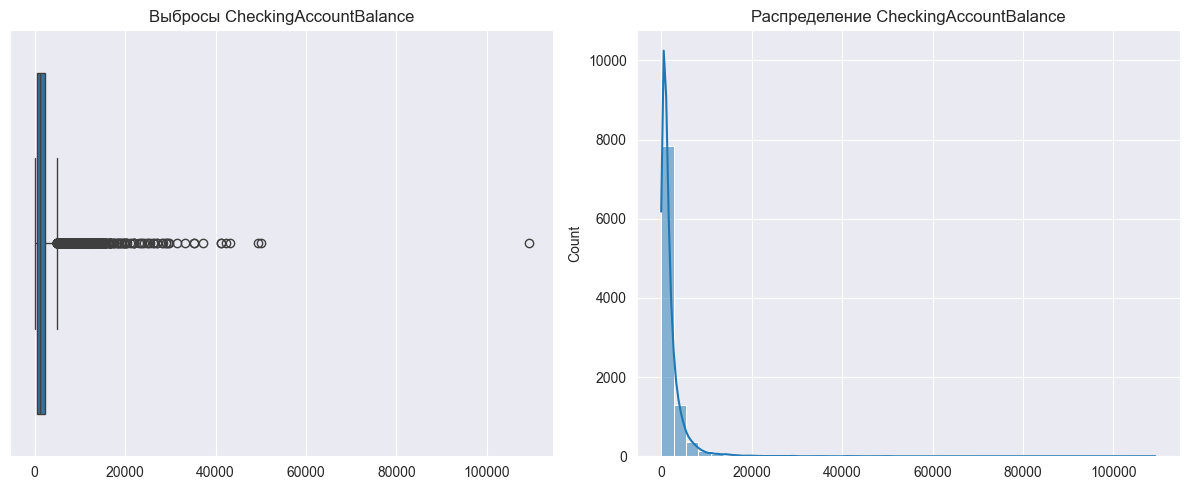

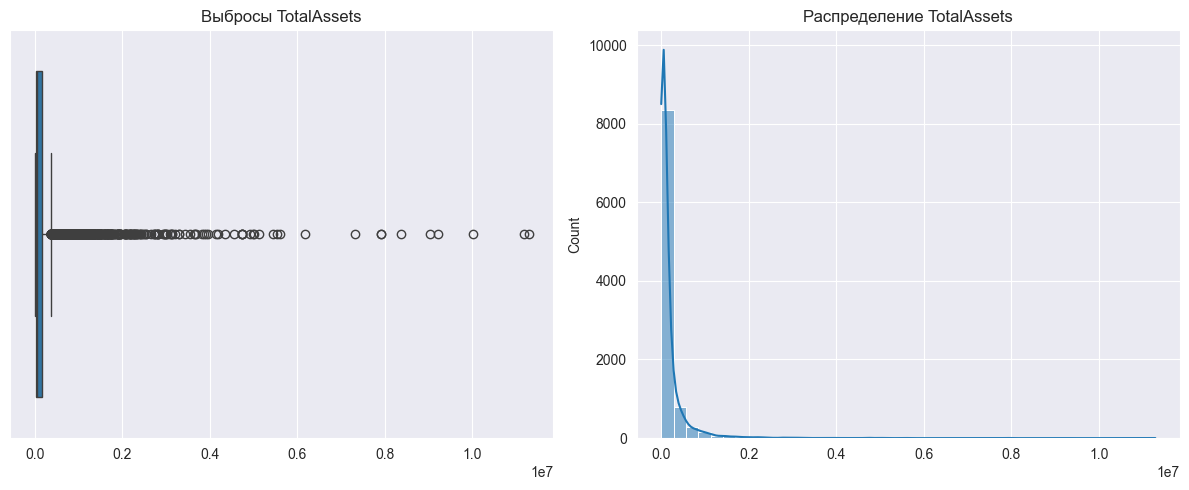

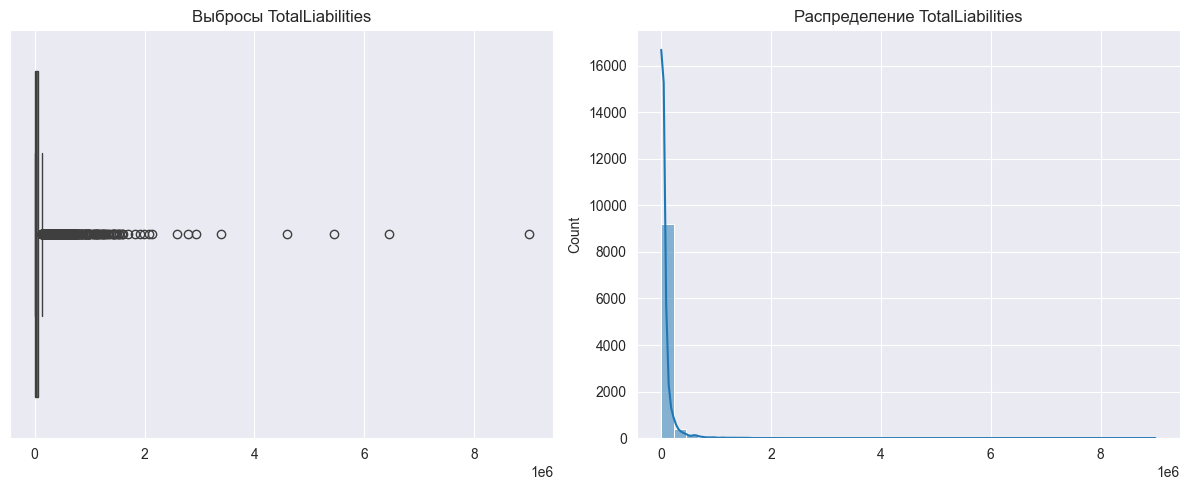

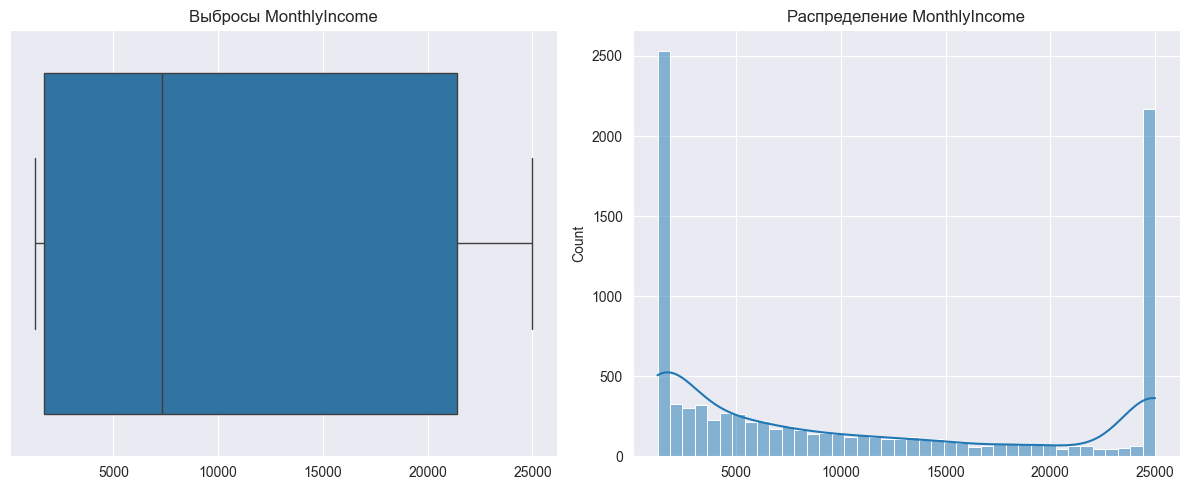

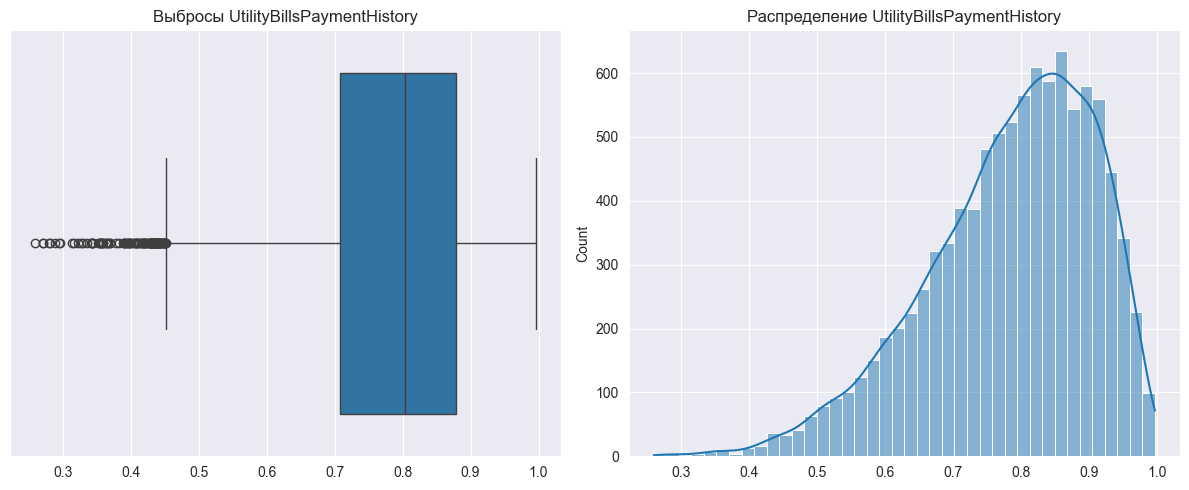

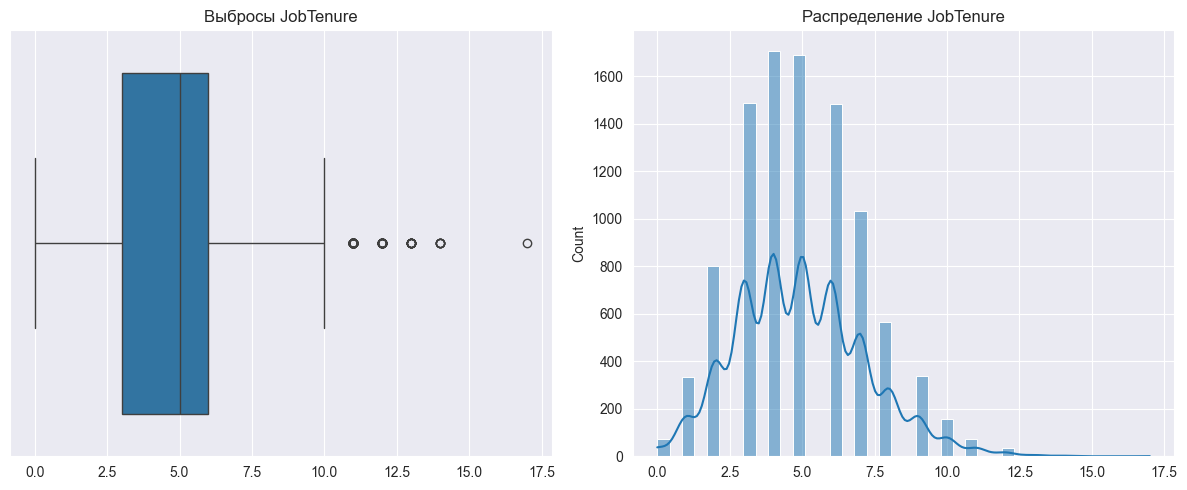

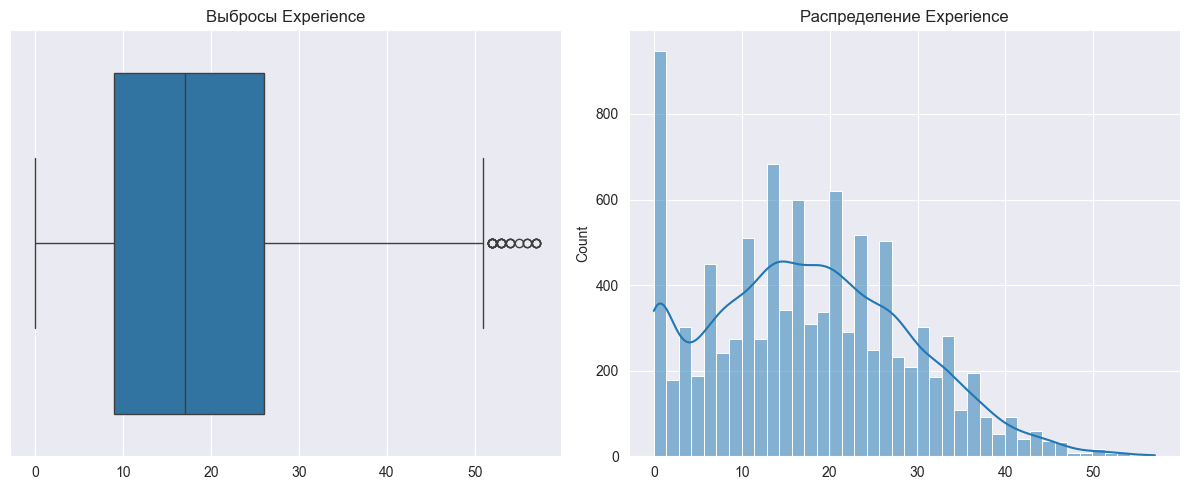

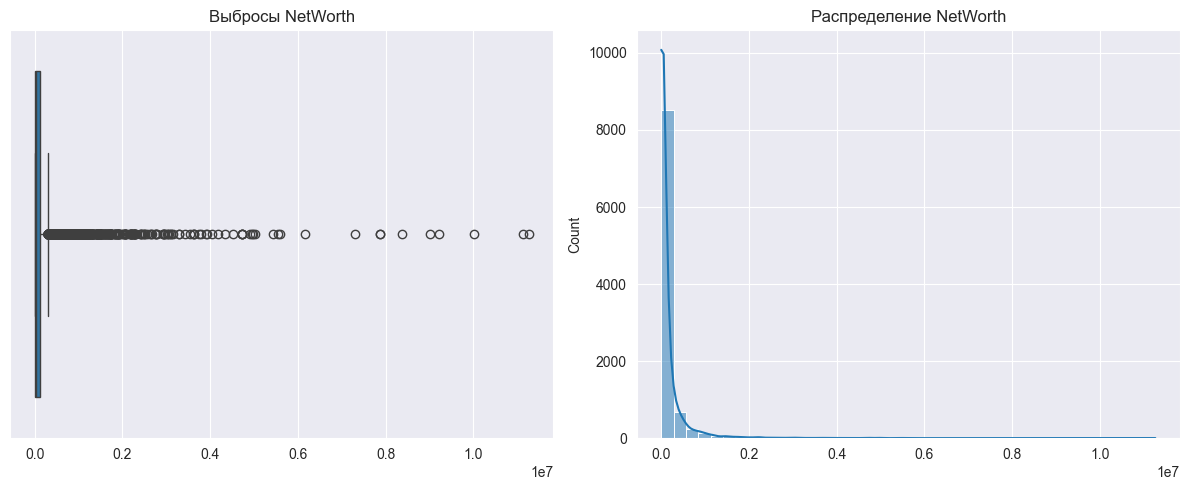

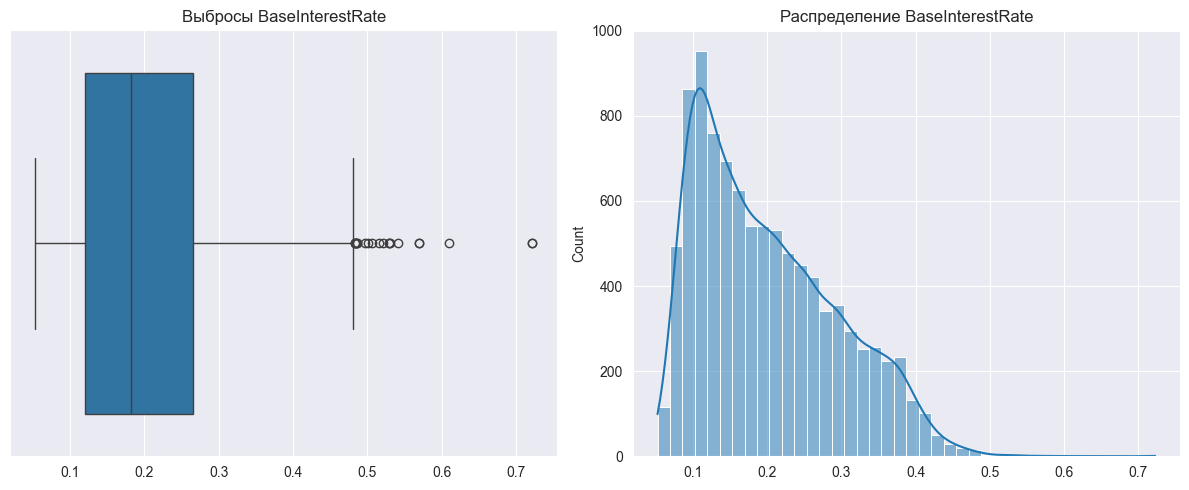

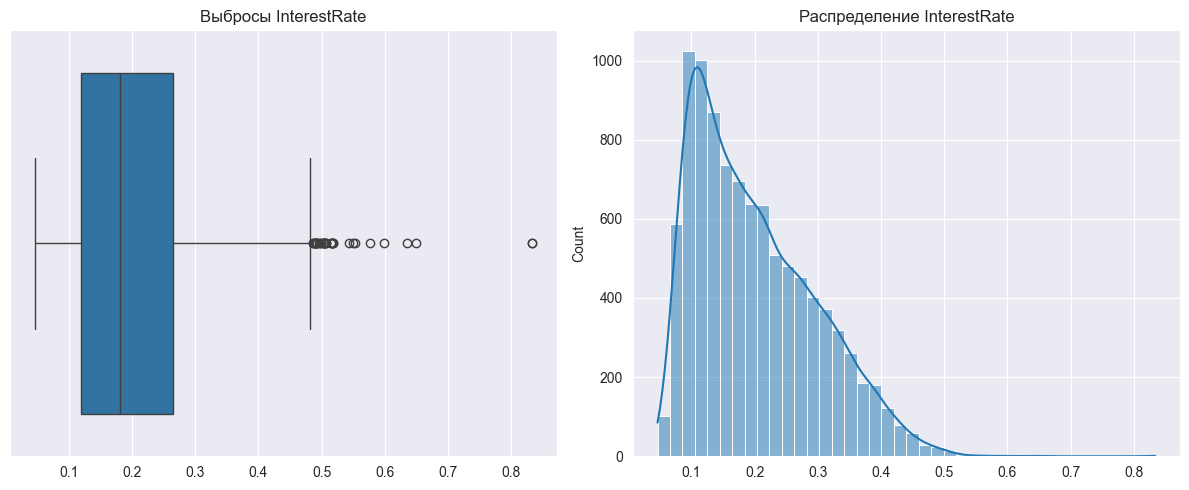

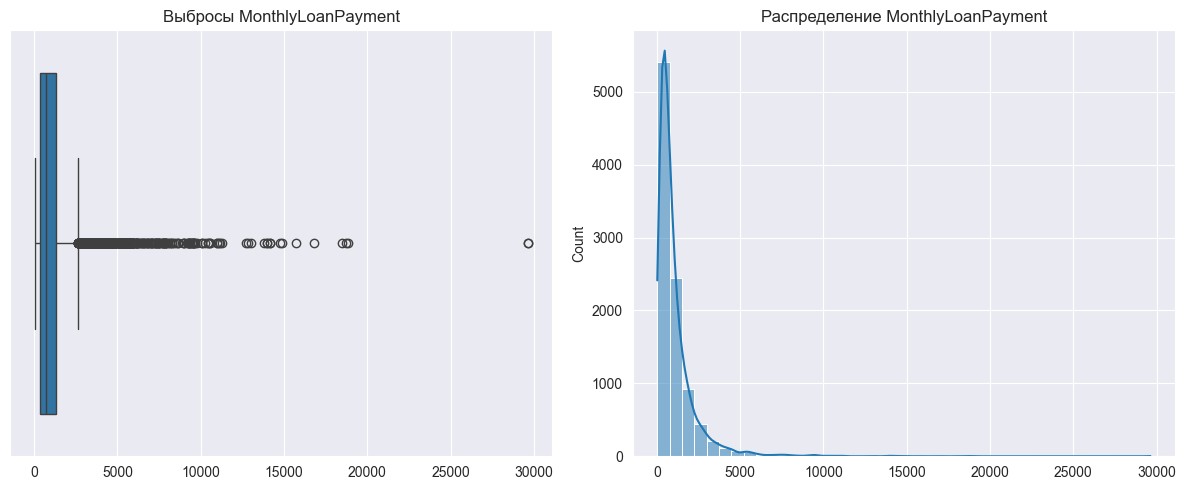

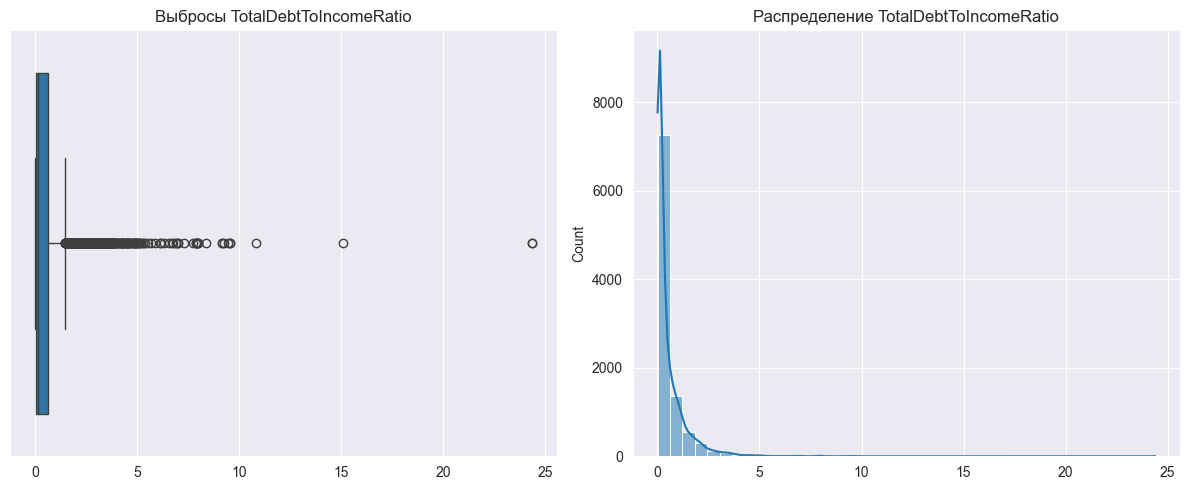

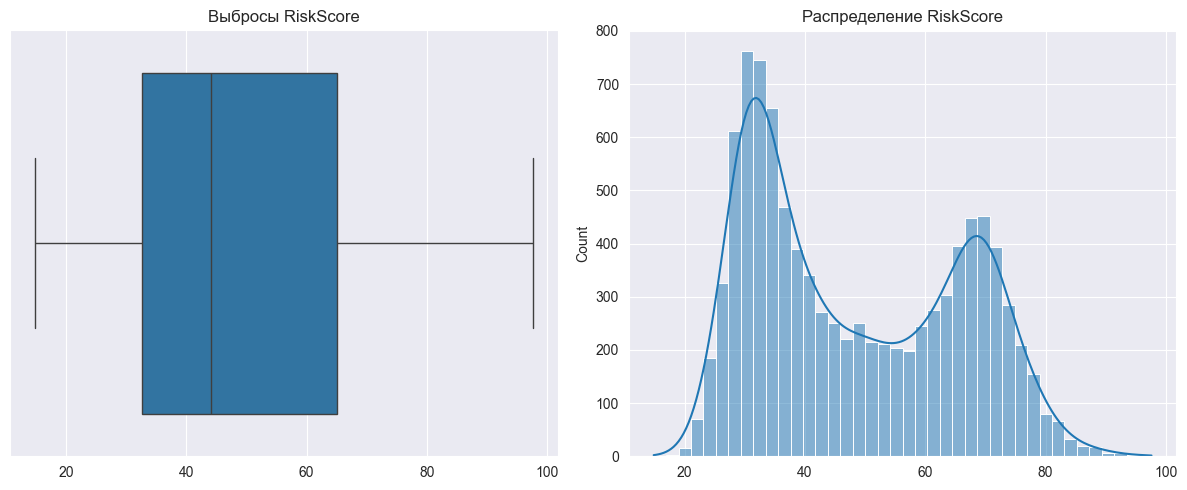

27


In [99]:
counter = 0
for col in numeric_cols:
    if col in pseudo_numeric:
        continue
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_[col])
    plt.title(f'Выбросы {col}')
    plt.xlabel('')


    plt.subplot(1, 2, 2)
    sns.histplot(df_[col], kde=True, bins=40)
    plt.title(f'Распределение {col}')
    plt.xlabel('')

    plt.tight_layout()
    plt.show()
    counter += 1

print(counter)

Посмотрим количественно на категориальные признаки

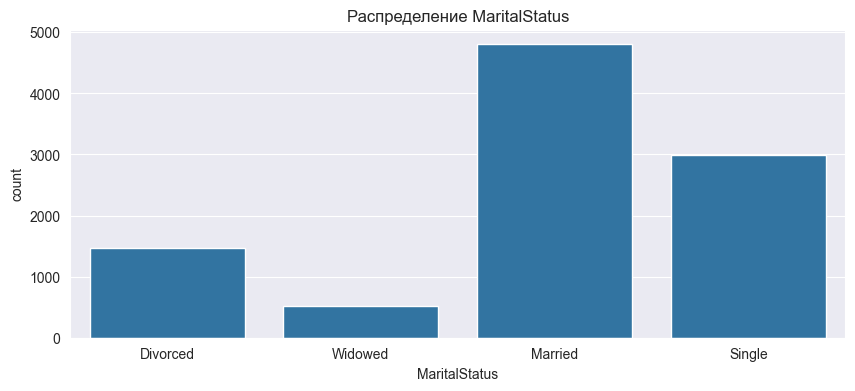

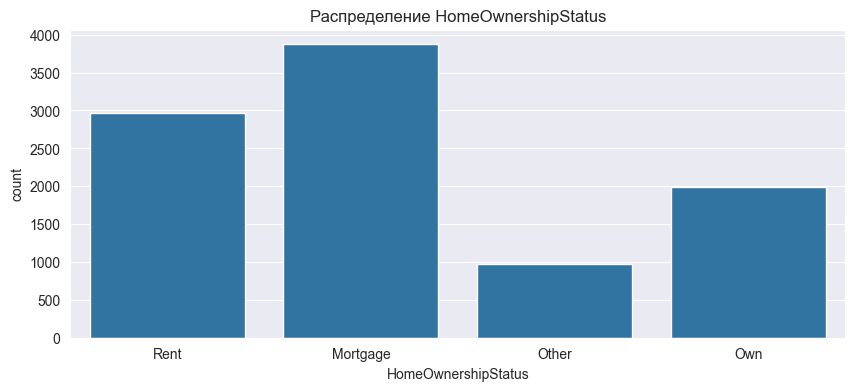

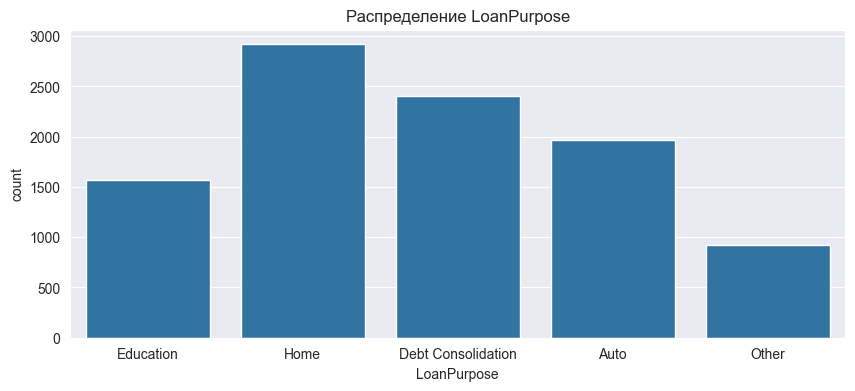

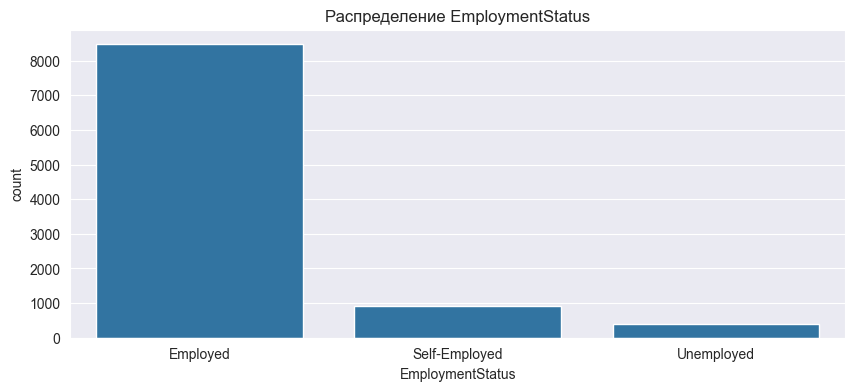

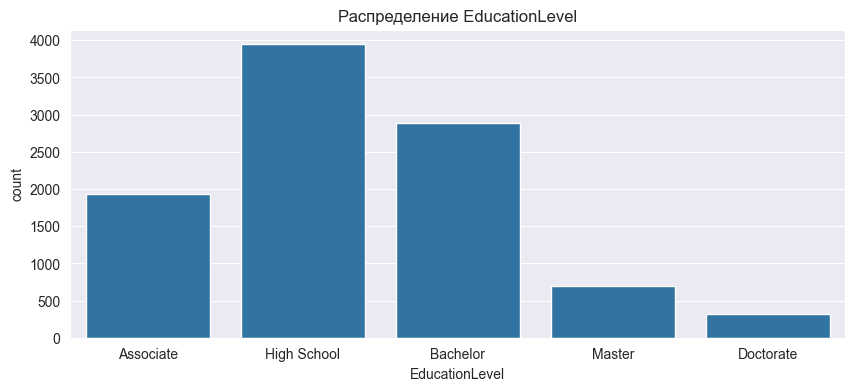

In [100]:
for col in categorical_cols:
    if col == 'ApplicationDate': # это дата время удалим в будущем
        continue
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df_, x=col)
    plt.xticks(rotation=0)
    plt.title(f'Распределение {col}')
    plt.show()

Посмотрим на псевдо-числовые признаки и убедимся в этоми благодаря просмотру распредедения

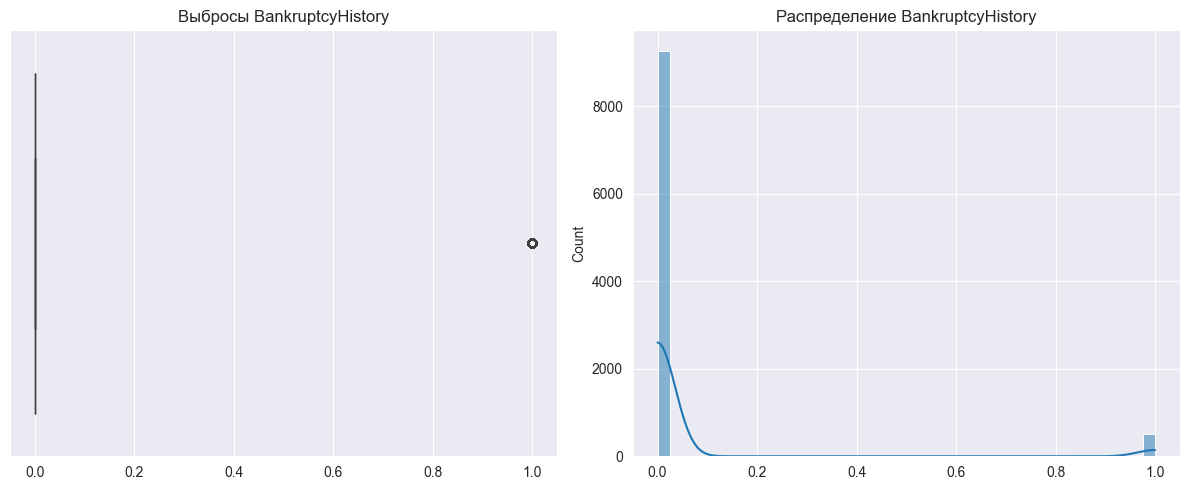

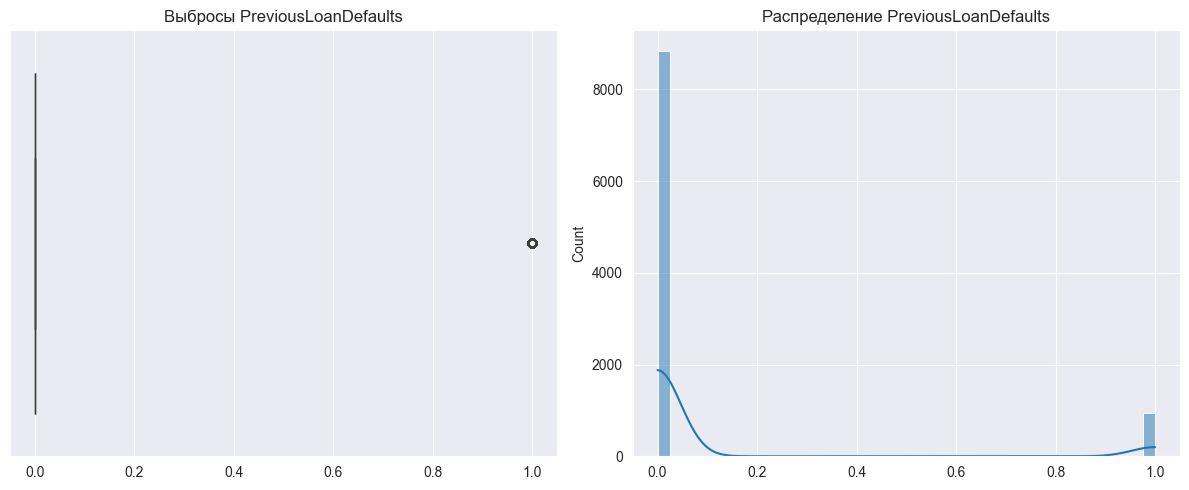

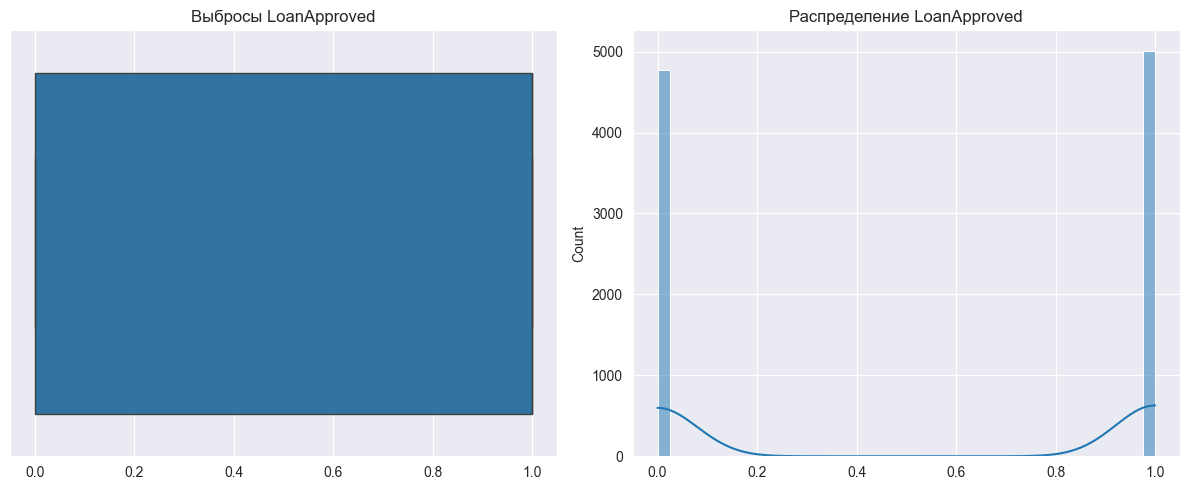

In [101]:
for col in pseudo_numeric:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_[col])
    plt.title(f'Выбросы {col}')
    plt.xlabel('')


    plt.subplot(1, 2, 2)
    sns.histplot(df_[col], kde=True, bins=40)
    plt.title(f'Распределение {col}')
    plt.xlabel('')

    plt.tight_layout()
    plt.show()


8. Теперь будем разделять категориальные признаки на числовые или бинарные

In [107]:
print(categorical_cols)

df = df_.copy()

print(df.shape[1])

#разделю ApplicationDate на отдельные составляющие

df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
df['Year'] = df['ApplicationDate'].dt.year
df['Month'] = df['ApplicationDate'].dt.month
df['Day'] = df['ApplicationDate'].dt.day
df['DayOfWeek'] = df['ApplicationDate'].dt.dayofweek
df['DayOfYear'] = df['ApplicationDate'].dt.dayofyear

print(df.shape[1])

df = df.drop('ApplicationDate', axis=1)

print(df.shape[1])

print(df.head(3))

for col in categorical_cols:
    if col == "ApplicationDate":
        continue
    prefix = col
    df = pd.get_dummies(df, columns=[col], prefix=prefix)




for col in pseudo_numeric:
    median_val = df[col].mean()
    print(col + " :   " + str(median_val))
    df[f'{col}_group'] = (df[col] > median_val)
    df.drop(col, axis=1, inplace=True)

print(df['LoanApproved_group'].head(3))

print(pseudo_numeric)


# unique_values = df['EducationLevel'].unique()
# print(f"Уникальные значения: {unique_values}")
# print(f"Количество уникальных значений: {len(unique_values)}")

['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
36
41
40
    Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration MaritalStatus  \
0  27.0       66829.0        549.0     17290.0          60.0      Divorced   
1  55.0      172147.0        850.0     16110.0          36.0       Widowed   
2  51.0      300000.0        850.0     38436.0          36.0       Married   

   NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0                 1.0                Rent               1095.0   
1                 1.0            Mortgage                211.0   
2                 0.0            Mortgage                546.0   

   CreditCardUtilizationRate  ...  InterestRate  MonthlyLoanPayment  \
0                   0.151985  ...      0.251465          508.970230   
1                   0.175693  ...      0.093173          514.675859   
2                   0.444605  ...      0.115443         1268.276385   

   TotalDebtToI

In [108]:
print(tabulate([(col, dtype) for col, dtype in zip(df.columns, df.dtypes)],
               headers=['Признак', 'Тип данных'], tablefmt='grid'))

+--------------------------------+--------------+
| Признак                        | Тип данных   |
+================================+==============+
| Age                            | float64      |
+--------------------------------+--------------+
| AnnualIncome                   | float64      |
+--------------------------------+--------------+
| CreditScore                    | float64      |
+--------------------------------+--------------+
| LoanAmount                     | float64      |
+--------------------------------+--------------+
| LoanDuration                   | float64      |
+--------------------------------+--------------+
| NumberOfDependents             | float64      |
+--------------------------------+--------------+
| MonthlyDebtPayments            | float64      |
+--------------------------------+--------------+
| CreditCardUtilizationRate      | float64      |
+--------------------------------+--------------+
| NumberOfOpenCreditLines        | float64      |


Отлично теперь у меня есть только числовые признаки в моих данных

Топ-10 самых коррелирующих признаков:
                         RiskScore
LoanApproved_group       -0.872722
CreditScore              -0.785425
MonthlyIncome            -0.770608
BaseInterestRate          0.758712
AnnualIncome             -0.758480
InterestRate              0.742940
TotalDebtToIncomeRatio    0.532384
BankruptcyHistory_group   0.177559
MonthlyLoanPayment        0.151459
TotalAssets              -0.145735




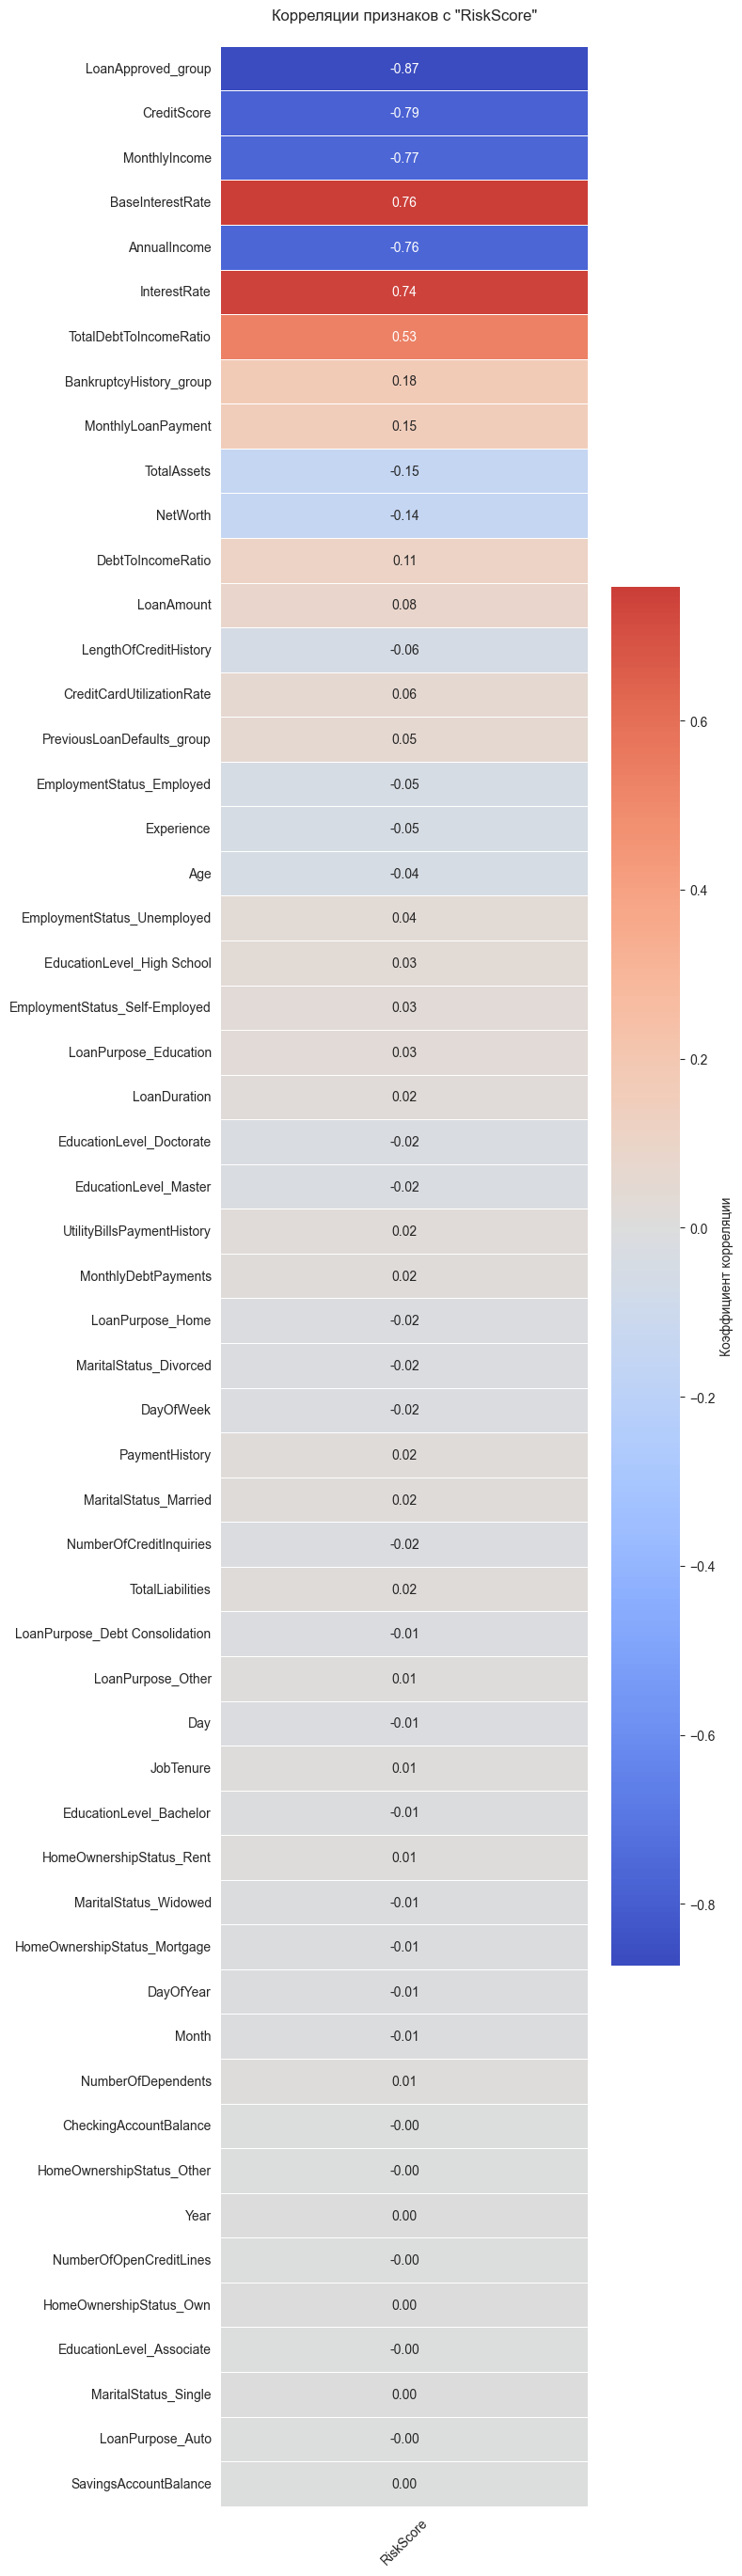

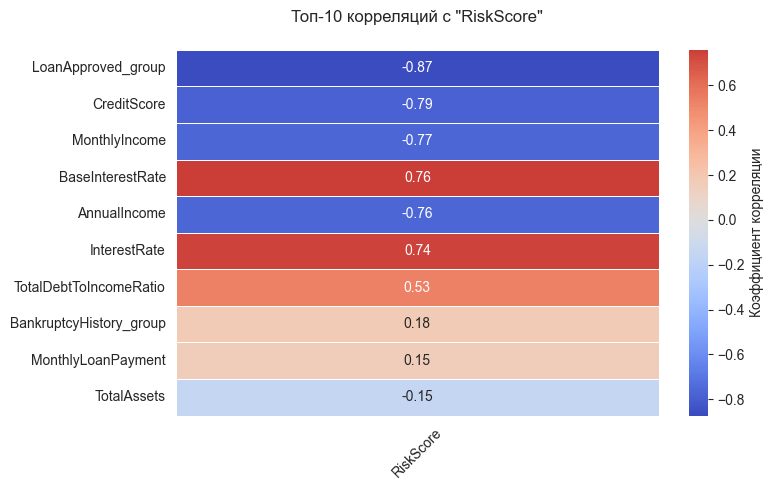

In [115]:

# cols = df.select_dtypes(include=['number', 'bool']).columns
#
# if target_col not in cols:
#     print(f"Ошибка: '{target_col}' не числовая переменная. Тип: {df[target_col].dtype}")
# else:
#     correlations = df[numeric_cols].corr()[[target_col]].drop(target_col)
#
#     correlations = correlations.iloc[(-correlations[target_col].abs()).argsort()]
#
#     plt.figure(figsize=(8, max(6, len(correlations)*0.5)))
#     sns.heatmap(correlations,
#                 cmap='coolwarm',
#                 center=0,
#                 annot=True,
#                 fmt=".2f",
#                 linewidths=0.5,
#                 cbar_kws={'label': 'Коэффициент корреляции'})
#
#     plt.title(f'Корреляции признаков с "{target_col}"', pad=20)
#     plt.yticks(rotation=0)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()


cols = df.select_dtypes(include=['number', 'bool']).columns

if target_col not in cols:
    print(f"Ошибка: '{target_col}' не числовая переменная. Тип: {df[target_col].dtype}")
else:
    correlations = df[cols].corr()[[target_col]].drop(target_col)
    correlations = correlations.iloc[(-correlations[target_col].abs()).argsort()]

    print("Топ-10 самых коррелирующих признаков:")
    top_10 = correlations.head(10)
    print(top_10)
    print("\n" + "="*50 + "\n")


    plt.figure(figsize=(8, max(6, len(correlations)*0.5)))
    sns.heatmap(correlations,
                cmap='coolwarm',
                center=0,
                annot=True,
                fmt=".2f",
                linewidths=0.5,
                cbar_kws={'label': 'Коэффициент корреляции'})

    plt.title(f'Корреляции признаков с "{target_col}"', pad=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))  # Фиксированный размер для 10 признаков
    sns.heatmap(top_10,
                cmap='coolwarm',
                center=0,
                annot=True,
                fmt=".2f",
                linewidths=0.5,
                cbar_kws={'label': 'Коэффициент корреляции'})
    plt.title(f'Топ-10 корреляций с "{target_col}"', pad=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
